In [1]:
from mlcolvar.cvs import DeepLDA, DeepTDA
from mlcolvar.data import DictDataset, DictModule
from mlcolvar.core.transform import Statistics

import numpy as np
import mdtraj as md
import nglview as nv
import torch
import lightning
import pickle
import pyemma
np.bool = np.bool_

from tqdm import tqdm
from pytorch_lightning import Trainer

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

base_dir = "../DESRES-Trajectory_CLN025-0-protein"

In [2]:
pdb_path = "../data/CLN025.pdb"
traj = md.load_pdb(pdb_path)
view = nv.show_mdtraj(traj)
view.add_representation("licorice", selection="protein")
view

NGLWidget()

## Dataset

In [4]:
data_path = f"{base_dir}/CLN025-0-CAdistance-switch.pt"
data = torch.load(data_path)
print(data.shape)

torch.Size([530000, 45])


In [5]:
new_dataset = DictDataset({
	"data": data[5:],
	"target": data[:-5]
})
datamodule = DictModule(new_dataset,lengths=[0.8,0.2])

## Train

In [6]:
import torch

from typing import Optional
from torch.optim import Adam

from mlcolvar.cvs import VariationalAutoEncoderCV
from mlcolvar.core.loss.elbo import elbo_gaussians_loss

        
class VDELoss(torch.nn.Module):
    def forward(
        self,
        target: torch.Tensor,
        output: torch.Tensor,
        mean: torch.Tensor,
        log_variance: torch.Tensor,
        z_t: torch.Tensor,
        z_t_tau: torch.Tensor,
        weights: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        elbo_loss = elbo_gaussians_loss(target, output, mean, log_variance, weights)
        auto_correlation_loss = 0
        
        z_t_mean = z_t.mean(dim=0)
        z_t_tau_mean = z_t_tau.mean(dim=0)
        z_t_centered = z_t - z_t_mean.repeat(z_t.shape[0], 1)
        z_t_tau_centered = z_t_tau - z_t_tau_mean.repeat(z_t_tau.shape[0], 1)
        
        # auto_correlation_loss = - (z_t_centered @ z_t_tau_centered.T)[torch.eye(z_t.shape[0], dtype=torch.bool, device = z_t.device)].mean()
        # auto_correlation_loss = auto_correlation_loss / (z_t.std(dim=0).T @ z_t_tau.std(dim=0))
        ac_num = z_t_centered.reshape(1, -1) @ z_t_tau_centered.reshape(-1, 1)
        ac_den = z_t_centered.norm(2) * z_t_tau_centered.norm(2)
        auto_correlation_loss = - ac_num / ac_den
        
        return elbo_loss, auto_correlation_loss
        
        
class VariationalDynamicsEncoder(VariationalAutoEncoderCV):
    def __init__(
        self,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # =======   LOSS  =======
        # ELBO loss function when latent space and reconstruction distributions are Gaussians.
        self.loss_fn = VDELoss()
        self.optimizer = Adam(self.parameters(), lr=1e-4)
    
    def backward(self, loss):
        loss.backward(retain_graph=True)
    
    def training_step(
        self,
        train_batch, 
        batch_idx
    ):
        x = train_batch["data"]
        input = x
        loss_kwargs = {}
        if "weights" in train_batch:
            loss_kwargs["weights"] = train_batch["weights"]

        # Encode/decode.
        mean, log_variance, x_hat = self.encode_decode(x)

        # Reference output (compare with a 'target' key if any, otherwise with input 'data')
        if "target" in train_batch:
            x_ref = train_batch["target"]
        else:
            x_ref = x
        
        # Values for autocorrealtion loss
        if self.norm_in is not None:
            input_normalized = self.norm_in(input)
            x_ref_normalized = self.norm_in(x_ref)
        z_t = self.encoder(input_normalized)
        z_t_tau = self.encoder(x_ref_normalized)
        
        # Loss function.
        elbo_loss, auto_correlation_loss = self.loss_fn(
            x_ref, x_hat, mean, log_variance,
            z_t, z_t_tau,
            **loss_kwargs
        )

        # Log.
        name = "train" if self.training else "valid"
        self.log(f"{name}_elbo_loss", elbo_loss, on_epoch=True)
        self.log(f"{name}_auto_correlation_loss", auto_correlation_loss, on_epoch=True)
        self.log(f"{name}_loss", elbo_loss + auto_correlation_loss, on_epoch=True)

        return elbo_loss + auto_correlation_loss

In [7]:
options = {
	"encoder": {
		"activation": "relu",
		"dropout": [0.3, 0.3, 0.3],
		"last_layer_activation": True
	}
}
model = VariationalDynamicsEncoder(
    n_cvs=1,
    encoder_layers=[45, 24, 12, 1],
    options=options
)
model

VariationalDynamicsEncoder(
  (loss_fn): VDELoss()
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=24, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=24, out_features=12, bias=True)
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.3, inplace=False)
      (6): Linear(in_features=12, out_features=1, bias=True)
      (7): ReLU(inplace=True)
      (8): Dropout(p=0.3, inplace=False)
    )
  )
  (mean_nn): Linear(in_features=1, out_features=1, bias=True)
  (log_var_nn): Linear(in_features=1, out_features=1, bias=True)
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=1, out_features=1, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1, out_features=12, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=12, out_features=24, bias=True)


In [8]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=0.1, patience=50)

# define trainer
trainer = lightning.Trainer(
    callbacks=[metrics, early_stopping],
	max_epochs=None,
 	logger=None,
  	enable_checkpointing=False
)

# fit
trainer.fit( model, datamodule )
model.eval()

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packa

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

VariationalDynamicsEncoder(
  (loss_fn): VDELoss()
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=24, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=24, out_features=12, bias=True)
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.3, inplace=False)
      (6): Linear(in_features=12, out_features=1, bias=True)
      (7): ReLU(inplace=True)
      (8): Dropout(p=0.3, inplace=False)
    )
  )
  (mean_nn): Linear(in_features=1, out_features=1, bias=True)
  (log_var_nn): Linear(in_features=1, out_features=1, bias=True)
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=1, out_features=1, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1, out_features=12, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=12, out_features=24, bias=True)


In [9]:
import torch
from mlcolvar.core.transform import Transform


def sanitize_range(range: torch.Tensor):
    """Sanitize

    Parameters
    ----------
    range : torch.Tensor
        range to be used for standardization

    """

    if (range < 1e-6).nonzero().sum() > 0:
        print(
            "[Warning] Normalization: the following features have a range of values < 1e-6:",
            (range < 1e-6).nonzero(),
        )
    range[range < 1e-6] = 1.0

    return range

class PostProcess(Transform):
    def __init__(
        self,
        stats = None,
        reference_frame_cv = None,
        feature_dim = 1,
    ):
        super().__init__(in_features=feature_dim, out_features=feature_dim)
        self.register_buffer("mean", torch.zeros(feature_dim))
        self.register_buffer("range", torch.ones(feature_dim))
        
        if stats is not None:
            min = stats["min"]
            max = stats["max"]
            self.mean = (max + min) / 2.0
            range = (max - min) / 2.0
            self.range = sanitize_range(range)
        
        if reference_frame_cv is not None:
            self.register_buffer(
                "flip_sign",
                torch.ones(1) * -1 if reference_frame_cv < 0 else torch.ones(1)
            )
        else:
            self.register_buffer("flip_sign", torch.ones(1))
        
    def forward(self, x):
        x = x.sub(self.mean).div(self.range)
        x = x * self.flip_sign
        
        return x


## Evaluation

In [10]:
model.eval()
print(model)

VariationalDynamicsEncoder(
  (loss_fn): VDELoss()
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=24, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=24, out_features=12, bias=True)
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.3, inplace=False)
      (6): Linear(in_features=12, out_features=1, bias=True)
      (7): ReLU(inplace=True)
      (8): Dropout(p=0.3, inplace=False)
    )
  )
  (mean_nn): Linear(in_features=1, out_features=1, bias=True)
  (log_var_nn): Linear(in_features=1, out_features=1, bias=True)
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=1, out_features=1, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1, out_features=12, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=12, out_features=24, bias=True)


### Normalization and save

In [11]:
projection_data_path = f"{base_dir}/CLN025-0-CAdistance-switch.pt"
projection_data = torch.load(projection_data_path)
cv = model(projection_data)
cv = cv.detach().numpy()
print(cv.shape)

(530000, 1)


In [12]:
stats = Statistics(torch.from_numpy(cv).cpu()).to_dict()
model.postprocessing = PostProcess(stats).to(model.device)

In [13]:
postprocessed_cv = model(projection_data)
print(cv.max())
print(cv.min())
print(postprocessed_cv.max())
print(postprocessed_cv.min())

-0.81019086
-0.8356621
tensor(1.0000, grad_fn=<MaxBackward1>)
tensor(-1.0000, grad_fn=<MinBackward1>)


In [14]:
model_save_dir = "../simulations/model"
model_name = "vde-switch"

model.eval()
torch.save(model.state_dict(), f"{model_save_dir}/{model_name}.pt")

model.trainer = Trainer(logger=False, enable_checkpointing=False, enable_model_summary=False)
input_dim = datamodule.dataset["data"].shape[1]
random_input = torch.rand(1, input_dim).to(model.device)
traced_script_module = torch.jit.trace(model, random_input)
traced_script_module.save(f"{model_save_dir}/{model_name}-jit.pt")

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### TICA

In [15]:
with open(f'../data/CLN025_tica_model_switch.pkl', 'rb') as f:
    tica = pickle.load(f)
print(tica)

TICA(commute_map=False, dim=2, epsilon=1e-06, kinetic_map=True, lag=5,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)


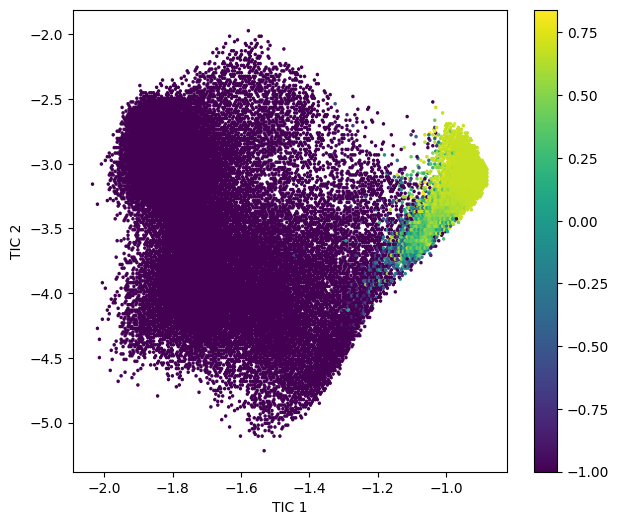

In [18]:
tica_coord = tica.transform(projection_data.numpy())
postprocessed_cv_numpy = postprocessed_cv.detach().cpu().numpy()


# Plot
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
hb = ax.hexbin(
	tica_coord[:, 0], tica_coord[:, 1], C=-postprocessed_cv_numpy[:, 0],  # data
	gridsize=200,                     # controls resolution
	reduce_C_function=np.mean,       # compute average per hexagon
	cmap='viridis',                  # colormap
)
plt.colorbar(hb)
# plt.scatter(tica_state[:, 0], tica_state[:, 1], c='red', s=10)
plt.xlabel("TIC 1")
plt.ylabel("TIC 2")
plt.show()

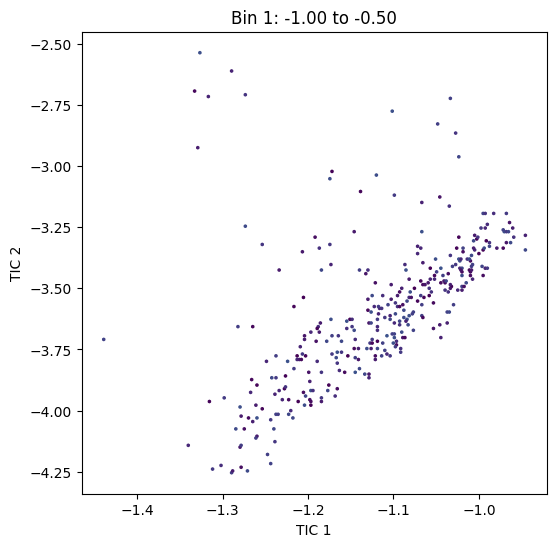

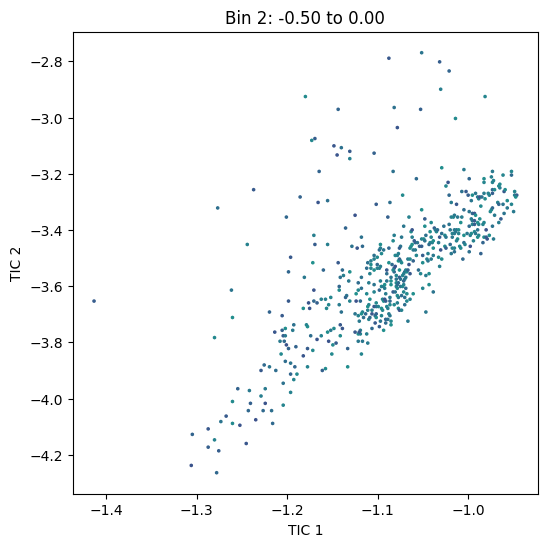

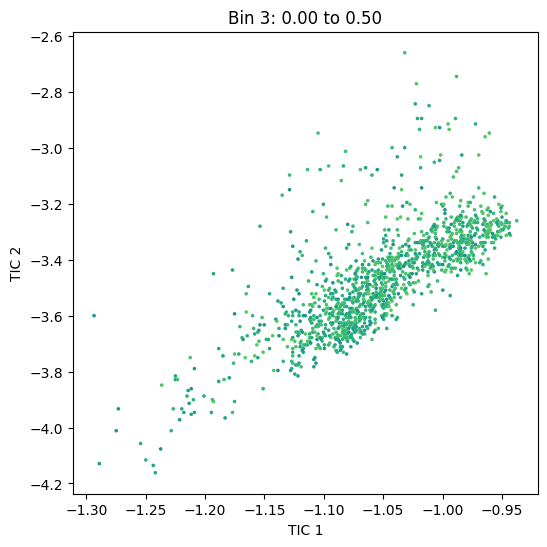

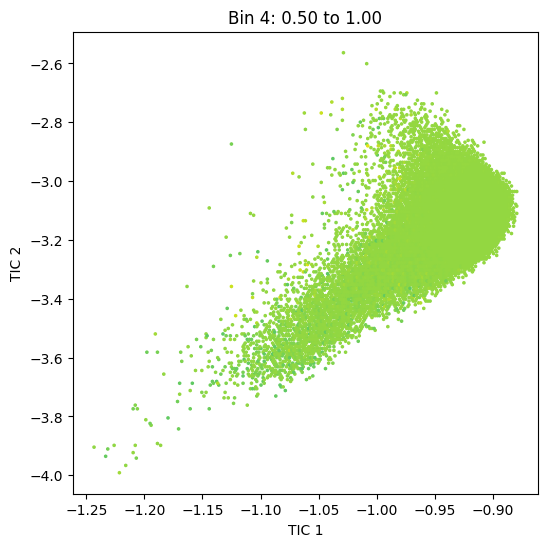

In [ ]:
boundaries = [-1, -0.5, 0, 0.5, 1]
vmin = -1
vmax = 1
sign_flipped_cv = -postprocessed_cv_numpy

for i in range(4):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    mask = (sign_flipped_cv[:, 0] >= boundaries[i]) & (sign_flipped_cv[:, 0] < boundaries[i+1])
    
    # Plot hexbin for selected frames
    hb = ax.hexbin(
        tica_coord[mask, 0],
        tica_coord[mask, 1],
        C=sign_flipped_cv[mask, 0],
        gridsize=200,
        cmap='viridis',
        vmin=vmin, vmax=vmax  # << here you fix color scale!
    )
    # ax.scatter(tica_state[:, 0], tica_state[:, 1], c='red', s=10)
    ax.set_title(f"Bin {i+1}: {boundaries[i]:.2f} to {boundaries[i+1]:.2f}")
    ax.set_xlabel("TIC 1")
    ax.set_ylabel("TIC 2")